In [29]:
using Dates, CSV, JuliaDB, Plots, PlotThemes, Interact, 
    HTTP, SingularSpectrumAnalysis, ProgressMeter
using OnlineStats
theme(:bright)

# OnlineStats and Big Data Viz

## `Partition` and `IndexedPartition`

- Plot any-sized dataset.
- Here are two plots with **100 Million observations**:

In [ ]:
o = Partition(Series(Mean(), Extrema()))

y = randn()

@showprogress for _ in 1:10^8
    fit!(o,  global y += randn())
end

plot(o)

Progress:  39%|███████████████▉                         |  ETA: 0:00:35

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


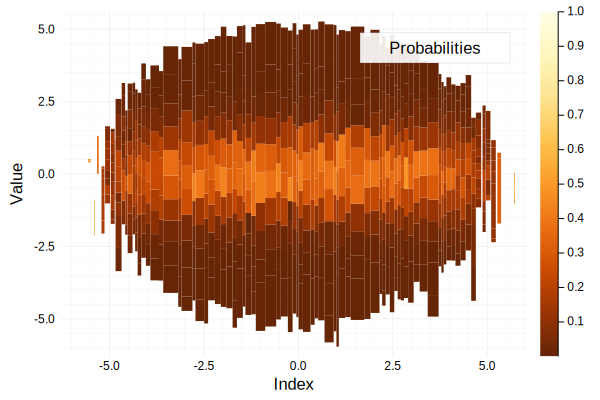

In [3]:
o = IndexedPartition(Float64, KHist(10))

@showprogress for _ in 1:10^8
    fit!(o,  (randn(), randn()))
end

plot(o)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Kaggle's [Huge Stock Market Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

- OHLC data for each stock/ETF (each is a separate CSV) traded in the US
- Just over 700MB

In [4]:
path = "/Users/joshday/datasets/price-volume-data-for-all-us-stocks-etfs/Stocks/"

readdir(path)

7195-element Array{String,1}:
 "a.us.txt"    
 "aa.us.txt"   
 "aaap.us.txt" 
 "aaba.us.txt" 
 "aac.us.txt"  
 "aal.us.txt"  
 "aamc.us.txt" 
 "aame.us.txt" 
 "aan.us.txt"  
 "aaoi.us.txt" 
 "aaon.us.txt" 
 "aap.us.txt"  
 "aapl.us.txt" 
 ⋮             
 "znh.us.txt"  
 "znwaa.us.txt"
 "zoes.us.txt" 
 "zsan.us.txt" 
 "zto.us.txt"  
 "ztr.us.txt"  
 "zts.us.txt"  
 "zumz.us.txt" 
 "zvv.us.txt"  
 "zx.us.txt"   
 "zyme.us.txt" 
 "zyne.us.txt" 

In [5]:
;head "$path/aapl.us.txt"

Date,Open,High,Low,Close,Volume,OpenInt
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
1984-09-14,0.44052,0.45589,0.44052,0.44566,68847968,0
1984-09-17,0.45718,0.46357,0.45718,0.45718,53755262,0
1984-09-18,0.45718,0.46103,0.44052,0.44052,27136886,0
1984-09-19,0.44052,0.44566,0.43157,0.43157,29641922,0


## Statistics/Plots Directly From CSV

- Via `CSV.File`

In [6]:
function plot_high_low(stock; kw...)
    o = IndexedPartition(Date, Extrema(), 500)
    for row in CSV.File("$path/$stock.us.txt") 
        fit!(o, [row.Date => row.Low, row.Date => row.High])
    end
    t = uppercase(stock) * " (nobs = $(nobs(o)))"
    plot(o; xlab="Date", title=t, legend=false, kw...)
end

plot_high_low (generic function with 1 method)

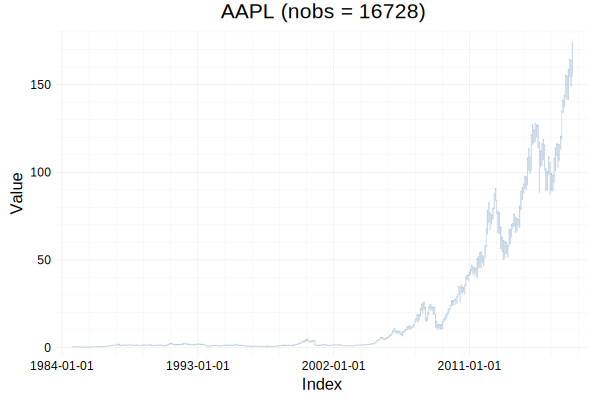

In [7]:
plot_high_low("aapl")

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## ...But this loads the entire CSV!

Even though we are creating the plots with OnlineStats, the entire file is loaded into memory.

### `CSV.Rows`

- `CSV.Rows` lets you lazily read from a CSV file
    - **Minimal memory footprint**
    - At the cost of **no type inference** (everything is treated as `String`)

In [8]:
function plot_high_low2(stock; kw...)
    o = IndexedPartition(Date, Extrema(), 500)
    for row in CSV.Rows("$path/$stock.us.txt")
        dt = Date(row.Date, "yyyy-mm-dd")
        low = parse(Float64, row.Low)
        hi = parse(Float64, row.High)
        fit!(o, [dt => low, dt => hi])
    end
    t = uppercase(stock) * " (nobs = $(nobs(o)))"
    plot(o; xlab="Date", title=t, legend=false, kw...)
end

plot_high_low2 (generic function with 1 method)

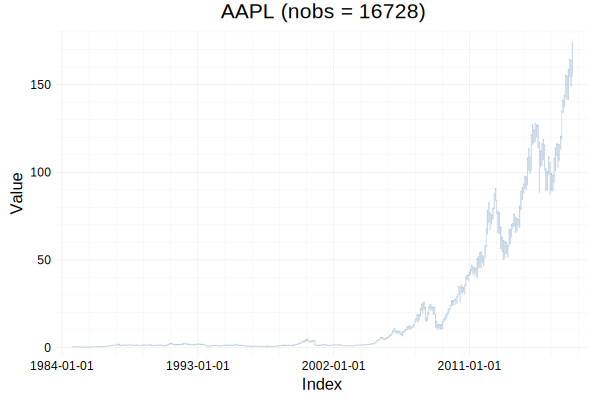

In [9]:
plot_high_low2("aapl")

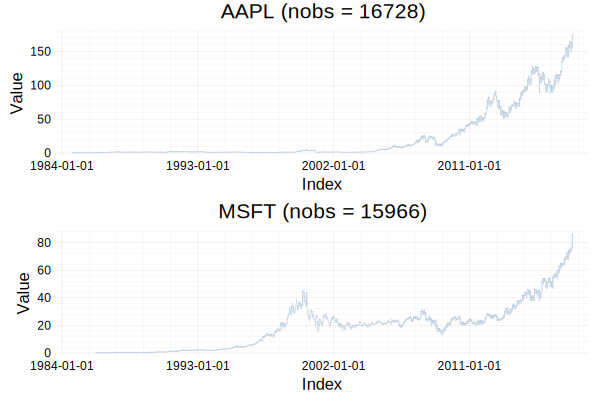

In [10]:
plot(plot_high_low2("aapl"), plot_high_low2("msft"), layout=(2,1), link=:x)

<br><br><br><br><br><br><br><br><br><br><br><br><br>

## Loading Multiple Datasets at Once

- Working with only one CSV at a time limits what kinds of analyses we can do.

In [11]:
t = loadtable(path, filenamecol = :Stock)

Table with 14887665 rows, 8 columns:
Stock          Date        Open    High     Low      Close   Volume    OpenInt
──────────────────────────────────────────────────────────────────────────────
"a.us.txt"     1999-11-18  30.713  33.754   27.002   29.702  66277506  0
"a.us.txt"     1999-11-19  28.986  29.027   26.872   27.257  16142920  0
"a.us.txt"     1999-11-22  27.886  29.702   27.044   29.702  6970266   0
"a.us.txt"     1999-11-23  28.688  29.446   27.002   27.002  6332082   0
"a.us.txt"     1999-11-24  27.083  28.309   27.002   27.717  5132147   0
"a.us.txt"     1999-11-26  27.594  28.012   27.509   27.807  1832635   0
"a.us.txt"     1999-11-29  27.676  28.65    27.38    28.432  4317826   0
"a.us.txt"     1999-11-30  28.35   28.986   27.634   28.48   4567146   0
"a.us.txt"     1999-12-01  28.48   29.324   28.273   28.986  3133746   0
"a.us.txt"     1999-12-02  29.532  30.375   29.155   29.786  3252997   0
"a.us.txt"     1999-12-03  30.336  30.842   29.909   30.039  3223074   0
"a

### Passing an `OnlineStat` as a reducer

In [12]:
reduce(Mean(), t, select=(:Open, :Close) => x -> -(x...))

Mean: n=14887665 | value=140.164

### `groupreduce`

- Like `groupby`, but **much** more memory efficient!

In [13]:
temp = groupreduce(Mean(), t, :Stock, select=:Open)
select(temp, (1, 2 => value))

Table with 7163 rows, 2 columns:
1              2
──────────────────────
"a.us.txt"     27.8563
"aa.us.txt"    24.4198
"aaap.us.txt"  37.2295
"aaba.us.txt"  25.4017
"aac.us.txt"   19.5104
"aal.us.txt"   41.1502
"aamc.us.txt"  275.233
"aame.us.txt"  2.79986
"aan.us.txt"   23.1782
"aaoi.us.txt"  24.6174
"aaon.us.txt"  12.5343
"aap.us.txt"   79.5119
⋮
"znh.us.txt"   21.0289
"zoes.us.txt"  28.3315
"zsan.us.txt"  3.44271
"zto.us.txt"   14.078
"ztr.us.txt"   8.72918
"zts.us.txt"   42.9409
"zumz.us.txt"  23.4661
"zvv.us.txt"   97.688
"zx.us.txt"    2.28783
"zyme.us.txt"  9.07056
"zyne.us.txt"  13.5845

### Make All Plots at Once

In [14]:
allplots = groupreduce(IndexedPartition(Date, Extrema()), t, :Stock, select=(:Date, :Close))

Table with 7163 rows, 2 columns:
Columns:
#  colname           type
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1  Stock             String
2  IndexedPartition  IndexedPartition{Date,Number,Extrema{Float64,Number},Part{ClosedInterval{Date},Extrema{Float64,Number}}}

In [15]:
@manipulate for s in ["aapl", "msft", "ibm", "googl", "nflx"]
    t2 = filter(==("$s.us.txt"), allplots, select=:Stock)
    plot(t2[1].IndexedPartition, title=s)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["s"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol,Any}(:attributes => ("data-bind" => "foreach : options_js"),:className => "buttons has-addons is-centered"))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}())], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("options_js" => (Observable{Any} with 1 listeners. Value:
OrderedDict[OrderedDict{String,Any}("key" => "aapl","val" => 1,"id" => "idHQLVnBRT"), OrderedDict{String,Any}("key" => "msft","val" => 2,"id" => "ideqnm6G7Y"), OrderedDict{String,Any}("key" => "ibm","val" => 3,"id" => "idh0ppqeKb"), OrderedDict{String,Any}("key" => "googl","val" => 4,"id" => "idKfpOgkKv"), OrderedDict{String,Any}("key" => "nflx","val" => 5,"id" => "idmQLZG1Eg")], nothing),"index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/joshday/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/joshday/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/joshday/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/joshday/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/joshday/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001211f1450, Task (runnable) @0x00000001211f1450), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                ele

<br><br><br><br><br><br><br><br><br><br><br><br><br>

## Time Series Analysis Tools

### Singular Spectrum Analysis

- Extract seasonal components out of a time series
- Calculated "offline", but a useful tool

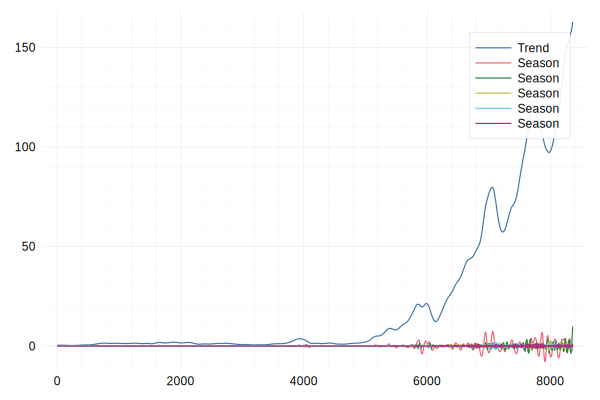

In [16]:
temp = filter(==("aapl.us.txt"), t, select=:Stock)

yt, ys = analyze(select(temp, :Close), 90)
plot(yt, lab="Trend")
plot!(ys, lab="Season")

### Autocorrelation

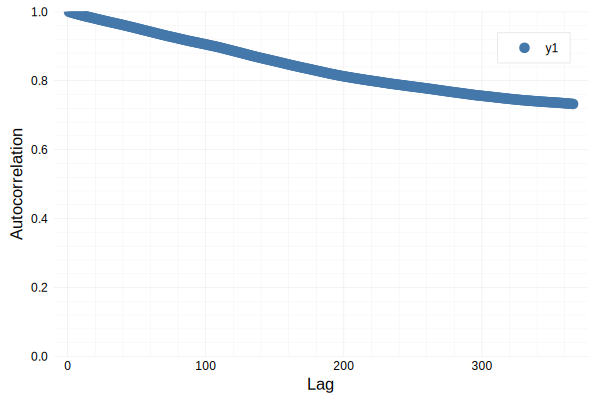

In [17]:
temp = filter(==("aapl.us.txt"), t, select=:Stock)


plot(fit!(AutoCov(365), select(temp, :Close)))

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# TrueFX API

In [18]:
function get_data(q = "")
    endpoint = "https://webrates.truefx.com/rates/connect.html?f=csv&$q"
    hdr = [:pair, :utc, :big_bid_figure, :bid_points, :offer_bid_figure,
           :offer_points, :high, :low, :open]
    r = HTTP.get(endpoint)
    CSV.read(r.body; header=hdr, footerskip=1)
end

get_data (generic function with 2 methods)

In [19]:
get_data("c=EUR/USD")

,pair,utc,big_bid_figure,bid_points,offer_bid_figure,offer_points
,String,Int64,Float64,Int64,Float64,Int64
1,EUR/USD,1584716025857,1.07,343,1.07,354


In [20]:
o = IndexedPartition(Int, Extrema(), 10)

while false
    IJulia.clear_output(true)
    df = get_data("c=USD/JPY")
    fit!(o, (df[1, :utc], df[1, :bid_points]))
    display(plot(o, xlab="UTC Time", ylab="Bid Points", title="nobs = $(nobs(o))"))
end

<br><br><br><br><br><br><br><br><br><br>
## NYC Yellow Taxi Data (2018)

- Data on every single yellow taxi trip in 2018!

In [21]:
datapath = "/Users/joshday/datasets/nyc_yellow_taxi_2018"

sum(filesize, ("$datapath/$file") for file in readdir(datapath)) / 1024^3

8.449579387903214

In [22]:
;head "$datapath/yellow_tripdata_2018-01.csv"

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount

1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,.50,1,N,41,24,2,4.5,0.5,0.5,0,0,0.3,5.8
1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.70,1,N,239,140,2,14,0.5,0.5,0,0,0.3,15.3
1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,.80,1,N,262,141,1,6,0.5,0.5,1,0,0.3,8.3
1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.20,1,N,140,257,2,33.5,0.5,0.5,0,0,0.3,34.8
1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.50,1,N,246,239,1,12.5,0.5,0.5,2.75,0,0.3,16.55
1,2018-01-01 00:29:29,2018-01-01 00:32:48,3,.50,1,N,143,143,2,4.5,0.5,0.5,0,0,0.3,5.8
1,2018-01-01 00:38:08,2018-01-01 00:48:24,2,1.70,1,N,50,239,1,9,0.5,0.5,2.05,0,0.3,12.35
1,2018-01-01 00:49:29,2018-01-01 00:51:53,1,.70,1,N,239,238,1,4,0.5,0.5,1,0,0.3,6.3


Progress: 100%|█████████████████████████████████████████| Time: 0:03:41


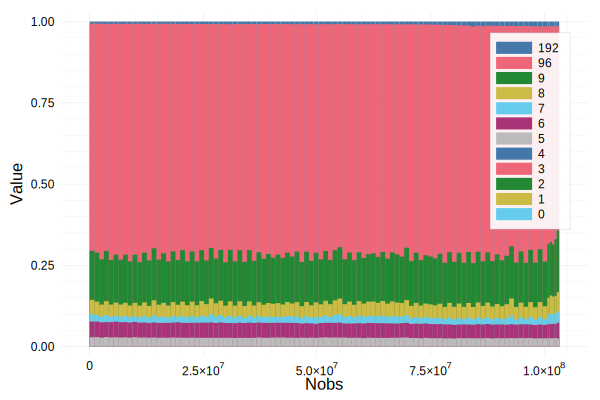

In [23]:
passenger_counts = Partition(CountMap(Int))
@showprogress for file in readdir(datapath), row in CSV.Rows("$datapath/$file", skipto=3)
    fit!(passenger_counts, parse(Int, row.passenger_count))
end
plot(passenger_counts)

### In Parallel

In [24]:
using Distributed
addprocs()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [25]:
@everywhere begin 
    datapath = "/Users/joshday/datasets/nyc_yellow_taxi_2018"
    using Dates, OnlineStats, CSV
end

@time begin
    gb = @distributed merge for file in readdir(datapath)
        stat = GroupBy(Date, CountMap(Int))
        for row in CSV.Rows("$datapath/$file", skipto=3)
            fit!(stat, Date(row.tpep_pickup_datetime[1:10]) => parse(Int, row.passenger_count))
        end
        stat
    end
end
nothing

 99.335225 seconds (2.57 M allocations: 130.184 MiB)


In [28]:
@manipulate for day in Date(2018,1,1):Day(1):Date(2018,12,31)
    plot(gb.value[day], title=string(day))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 365,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
183, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/joshday/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/joshday/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/joshday/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/joshday/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/joshday/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000014b0cc490, Task (runnable) @0x000000014b0cc490), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"2018-01-01\",\"2018-01-02\",\"2018-01-03\",\"2018-01-04\",\"2018-01-05\",\"2018-01-06\",\"2018-01-07\",\"2018-01-08\",\"2018-01-09\",\"2018-01-10\",\"2018-01-11\",\"2018-01-12\",\"2018-01-13\",\"2018-01-14\",\"2018-01-15\",\"2018-01-1